# Generate Birth Death Rates for Given Initial Conditions
Tim Tyree
8.11.2020

__bare minimum is this plus plotting the output by 3pm tomorrow__
- DONE: clean up these sections.  remove uneeded comments, redundant code
- DONE: save birth death rates to a file named according to all of the relevant parameters in a special folder. don't delete the last entry! it gives the termination time!
- DONE: move all parameters to the beginning of the notebook
- TODO: move notebook contents to sublimetext and call on a list of functions!
- TODO: make EP fields spread out into their own fields in the trajectories
- TODO: change the print statements to print to a log file 
- TODO: smooth out the filenames in sublimeText
- DONE: make asserting=True by default. (optional) make beeping=True by default
- TODO: make ext incrementing work again.  keep it simple, stupid!
__and then,__ 
run all nine grid squares, 

In [72]:
#pylab
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
# from pylab import imshow, show

#tracking
import numba, trackpy
# sklearn

#automate the boring stuff
# from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()

#are these even used?
from numba import njit, jit, vectorize
# import skimage as sk
from skimage import measure, filters
# from PIL import Image
# import imageio

#load the libraries
from lib import *
from lib.dist_func import *

#load the libraries
from lib.operari import *
from lib.ProgressBar import *
from lib.minimal_model import *
from lib.TexturePlot import *
from lib.get_tips import *
from lib.minimal_model import *
from lib.intersection import *

%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#the given initial conditions
sub_id = 33
initial_condition_dir = nb_dir + f'/Data/initial-conditions/ic_200x200.101.{sub_id}.npz'
data_dir =initial_condition_dir
# search_for_file()

In [3]:
################################        
###### START PARAMETERS ########
################################

#the given parameters

#printing/testing parameters
beeping   = True
asserting = True
printing  = True 
plotting  = False
#define parameters for tip detection
sigma       = 1.5
threshold   = 0.6
V_threshold = 0.5

edge_tolerance = 3
pad = 5
atol = 1e-11
color_values = None

h = 0.007
nsteps = 1*10**5 # int(1.8*10**5)#0#*10**4
save_every_n_frames = 100#nsteps#100#nsteps#10#50
max_time = h*nsteps
print( f"Will integrate up to no later than time = {max_time:.2f} milliseconds.")

# time_sig_figs = 4  #you need to change this manually below for pretty printing only!
max_buffers_to_save = 0
buffers_saved = 0
start_saving_buffers_at_step = 0#10**4 # nsteps/4
# tip_states = None
timing = False
recording_if_odd = True
recording = True
descrip = f'sigma_{sigma}_threshold_{threshold}'

#this saving overwrites the current save_file.  I check ahead of time that this won't happen with a "Caution! ... " print statement
save = True

#define parameters for tip tracking 
mem = 2 
sr  = 40 #?works sampling every 100 frames
# sr  = 1 #works sampling every frame

#trajectory filtering parameters
tmin = 50#100
LT_thresh = 0#2 #14 = 0.007*2000

#input/output filenames
base_save_dir = f"{nb_dir}/Data/ds_5_param_set_8"
save_folder = f'{nb_dir}/Data/ds_5_param_set_8' #no '/Log'

tip_log_fn = f'Log/{sub_id}_ds_5_sigma_{sigma}_threshold_{threshold}_.csv'
tip_log_dir = get_unique_file_name(os.path.join(save_folder, tip_log_fn), ext_string='.csv');
tip_position_dir = tip_log_dir.replace('.csv','_processed.csv')

data_dir_traj = base_save_dir+"/trajectories"
data_fn_traj = os.path.basename(tip_position_dir).replace('_processed.csv', f'_traj_sr_{sr}_mem_{mem}.csv')

save_folder_traj = '/'+os.path.join(*initial_condition_dir.split('/')[:-2])+'/ds_5_param_set_8/trajectories/'
birth_death_dir = '/'.join(save_folder_traj.split('/')[:-2])+'/birth-death-rates'
data_fn_bdrates = data_fn_traj.replace('.csv','_bdrates.csv')

#set the ending extension explicitely
ending_str = '_007.csv'
tip_log_dir = '_'.join ( tip_log_dir.split('_')[:-1] ) + ending_str
if printing:
    print(f"tip_log_dir is: \n\t{tip_log_dir}.")
    if (os.path.exists(tip_log_dir)):
        print(f"Caution! This tip_log_dir already exists!")
        
################################        
######## END PARAMETERS ########
################################

Will integrate up to no later than time = 700.00 milliseconds.
file name is unused - /Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/Log/33_ds_5_sigma_1.5_threshold_0.6_.csv
tip_log_dir is: 
	/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/Log/33_ds_5_sigma_1.5_threshold_0.6_007.csv.


# generate raw spiral tip data

In [4]:
# output_dir = get_unique_dir(path)
#deprecated
# output_dir = os.path.join(nb_dir, save_folder)
# if not os.path.exists(output_dir):
#     os.mkdir(output_dir)
# output_dir = os.path.join(nb_dir, save_folder) + '/Log'
# if not os.path.exists(output_dir):
#     os.mkdir(output_dir)

In [5]:
##############################################        
######## GENERATE TIP LOGS PARAMETERS ########
##############################################

print(f'loading initial conditions from: \n\t{initial_condition_dir}.')
os.chdir(nb_dir)
txt = load_buffer(initial_condition_dir)
width, height, channel_no = txt.shape

#reinitialize records
time_start = 0.  #eval(buffer_fn[buffer_fn.find('time_')+len('time_'):-4])
if asserting:
    assert (float(time_start) is not None)
tip_state_lst = []
tme = time_start

#change directory to where results are logged
os.chdir(save_folder)
if printing:
    print(f"changed directory to save_folder: \n\t{save_folder}.")

#precompute the _padded_ mesh coordinates
ycoord_mesh, xcoord_mesh = np.meshgrid(np.arange(0,txt.shape[0]+2*pad),np.arange(0,txt.shape[0]+2*pad))
nanstate = [np.nan,np.nan,np.nan]
channel_no = 3

loading initial conditions from: 
	/Users/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions/ic_200x200.101.33.npz.
changed directory to save_folder: 
	/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8.


In [6]:
# # jump forward a number of steps to see what happens to the buffer
# for j in range(500):
#     #integrate explicitely in time
#     time_step(txt, h=h, zero_txt=zero_txt) #up to twice as fast as for separated calls
#     tme += h

In [7]:
####This section may be skipped
# check all the functions work and compile the needed functions just in time
zero_txt = txt.copy()*0.
time_step(txt, h=h, zero_txt=zero_txt)

width, height, channel_no = txt.shape
zero_txt = np.zeros((width, height, channel_no), dtype=np.float64)
dtexture_dt = zero_txt.copy()
get_time_step(txt, dtexture_dt)

#calculate contours and tips after enforcing pbcs
img_nxt = txt[..., 0]#padded_txt#
img_inc = ifilter(dtexture_dt[..., 0])# ifilter(dpadded_txt_dt) #  #mask of instantaneously increasing voltages 
img_inc = filters.gaussian(img_inc,sigma=sigma, mode='wrap') 
img_nxt_unpadded = img_nxt.copy()
img_inc_unpadded = img_inc.copy()

img_nxt, img_inc = matrices_to_padded_matrices(img_nxt_unpadded, img_inc_unpadded,pad=pad)
txt_padded, dtexture_dt_padded = matrices_to_padded_matrices(txt, dtexture_dt,pad=pad)

contours_raw = measure.find_contours(img_nxt, level=V_threshold,fully_connected='low',positive_orientation='low')
contours_inc = measure.find_contours(img_inc, level=threshold)
tips  = get_tips(contours_raw, contours_inc)
tips_mapped = map_pbc_tips_back(tips=tips, pad=pad, width=width, height=height, 
                  edge_tolerance=edge_tolerance, atol = atol)
n_old = count_tips(tips_mapped[2])

#extract local EP field values for each tip
states_EP = get_states(tips_mapped, txt, pad, nanstate, xcoord_mesh, ycoord_mesh, channel_no = channel_no)
tips_mapped = add_states(tips_mapped, states_EP)
color_values = None

# # color by state value
# states_nearest, states_interpolated_linear, states_interpolated_cubic = states_EP
# chnl = 2
# # typs = 'nearest'
# # typs = 'linearly interpolated'
# typs = 'cubic-spline interpolated'
# state_value = np.array(states_interpolated_linear)[:,chnl]
# color_values = state_value
# print(f'plotting channel {chnl} \nof the {typs} states.')

# if printing:
    # #bluf
    # print('max value of change for each channel is {:.4f} , {:.4f}, {:.4f}.'.format(*tuple(np.max(txt,axis=(0,1)))))
    # print('max rate of change for each channel is {:.4f} , {:.4f}, {:.4f}.'.format(*tuple(np.max(dtexture_dt,axis=(0,1)))))

    # print(f"\n number of type 1 contour = {len(contours_raw)},\n number of type 2 contour = {len(contours_inc)},")
    # print(f"the number of tips are {n_old}. time is {tme:.1f} ms.")
    # print(f"note for time <100ms, I'm saying nothing about the accuracy of tip detection.")
    # print(f"""the topological tip state:{tips[0]}""")
    # print(f"""x position of tips: {tips[1]}""")
    # print(f"""y position of tips: {tips[2]}""")

# plotting = True
if plotting:
    #plot texture contours and tips. oh my!
    # img_nxt_unpadded = img_nxt[pad:-pad,pad:-pad]
    # img_inc_unpadded = img_inc[pad:-pad,pad:-pad]
    contours_raw_unpadded = measure.find_contours(img_nxt_unpadded, level=V_threshold,fully_connected='low',positive_orientation='low')
    contours_inc_unpadded = measure.find_contours(img_inc_unpadded, level=threshold)

    # #print texture information
    # describe(txt)

    fig = plot_buffer(img_nxt_unpadded, img_inc_unpadded, contours_raw_unpadded, contours_inc_unpadded, tips_mapped, 
                      figsize=(5,5),max_marker_size=400, lw=1, color_values=color_values);
    plt.show()
    # plt.close()

In [8]:
# txt
# tme

In [9]:
#integrate explicitely in time
state = np.zeros((txt.shape[0],txt.shape[1],4),dtype=np.float64)
if printing:
    print(f"sigma is {sigma}, threshold is {threshold}.")
    print(f"pad is {pad}, rejection_distance is edge_tolerance is {edge_tolerance}.")
    print(f"starting simulation.  integrating up to time {h*nsteps+tme:.3f} milliseconds.")
start = time.time()
for step in range(nsteps):
    recording = step%save_every_n_frames==0
    if not recording:
        #integrate explicitely in time
        time_step(txt, h=h, zero_txt=zero_txt) #up to twice as fast as for separated calls
        tme += h
    if recording:
        #calculate discrete flow map
        dtexture_dt = zero_txt.copy()
        get_time_step(txt, dtexture_dt)
        
        #pad texture for saving view 
        padded_txt, dpadded_txt_dt = textures_to_padded_textures(txt, dtexture_dt,pad=pad)
        
        #integrate explicitely in time by the forward euler method
        txt += h*dtexture_dt
        tme += h
        
        #calculate contours and tips after enforcing pbcs
        img_nxt = txt[..., 0]#padded_txt#
        img_inc = ifilter(dtexture_dt[..., 0])# ifilter(dpadded_txt_dt) #  #mask of instantaneously increasing voltages 
        img_inc = filters.gaussian(img_inc,sigma=sigma, mode='wrap') 
        img_nxt_unpadded = img_nxt.copy()
        img_inc_unpadded = img_inc.copy()
        img_nxt, img_inc = matrices_to_padded_matrices(img_nxt_unpadded, img_inc_unpadded,pad=pad)
        contours_raw = measure.find_contours(img_nxt, level=V_threshold,fully_connected='low',positive_orientation='low')
        contours_inc = measure.find_contours(img_inc, level=threshold)
        tips  = get_tips(contours_raw, contours_inc)
        tips_mapped = map_pbc_tips_back(tips=tips, pad=pad, width=width, height=height, 
                          edge_tolerance=edge_tolerance, atol = atol)

        #extract local EP field values for each tip
        states_EP = get_states(tips_mapped, txt, pad, nanstate, xcoord_mesh, ycoord_mesh, channel_no = channel_no)
        tips_mapped = add_states(tips_mapped, states_EP)

        #record spiral tip locations 
        s1_lst, s2_lst, x_lst, y_lst, states_nearest, states_interpolated_linear, states_interpolated_cubic = tips_mapped
        tip_state_lst.append({
                    't': float(tme),
                    'x': tuple(x_lst),
                    'y': tuple(y_lst),
                    's1': tuple(s1_lst),
                    's2': tuple(s2_lst),
            'states_interpolated_linear': tuple(states_interpolated_linear)
        })
#         #record spiral tip locations with all three types of EP_states computed
#         s1_lst, s2_lst, x_lst, y_lst, states_nearest, states_interpolated_linear, states_interpolated_cubic = tips_mapped
#         tip_state_lst.append({
#                     't': float(np.around(tme, time_sig_figs)),
#                     'x': tuple(x_lst),
#                     'y': tuple(y_lst),
#                     's1': tuple(s1_lst),
#                     's2': tuple(s2_lst),
#             'states_nearest': tuple(states_nearest),
#             'states_interpolated_linear': tuple(states_interpolated_linear),
#             'states_interpolated_cubic': tuple(states_interpolated_cubic),
#         })
        
        #determine if an odd number of tips were born        
        n = count_tips(tips_mapped[2]) #counts the number of '.' in the nested list of x positions or just a normal list
        dn = n - n_old
        n_old = n
        
        #save the state if save_state is True 
        #save_state = recording_if_odd & odd_event & odd_tip_number # ==> odd birth/death event has just occurred
        save_state = recording_if_odd & (dn%2!=0) & (n%2!=0)
        if save_state:
            #plot texture contours and tips. oh my!
            #img_nxt_unpadded = img_nxt[pad:-pad,pad:-pad]
            #img_inc_unpadded = img_inc[pad:-pad,pad:-pad]
            contours_raw_unpadded = measure.find_contours(img_nxt_unpadded, level=V_threshold,fully_connected='low',positive_orientation='low')
            contours_inc_unpadded = measure.find_contours(img_inc_unpadded, level=threshold)
            if printing:
                print(f'odd tip spotted at time {tme:.3f}! dn={dn} and n={n}...')
            fig = plot_buffer(img_nxt_unpadded, img_inc_unpadded, contours_raw_unpadded, contours_inc_unpadded, tips_mapped, 
                              figsize=(5,5), max_marker_size=200, lw=1, color_values = None);
            fig.savefig(f'plot_of_n_{n}_dn_{dn}_for_{descrip}_at_time_{tme:.1f}.pdf', bbox_inches='tight',pad_inches=0);
            plt.close();
            #save texture as an .npy file as desired
            if step>start_saving_buffers_at_step:
                if buffers_saved<max_buffers_to_save:
                    buffers_saved += 1
                    np.save(f'buffer_of_n_{n}_dn_{dn}_for_{descrip}_at_time_{tme:.1f}.npy', txt)
        #early stopping when spirals die out
        stop_early = (n==0) & (step>100) #np.max(txt[...,0])<0.1
        if stop_early:
            if printing:
                print(f'\nmax voltage is {np.max(txt[...,0]):.4f}.') 
                print(f"tip number = {n}.  stopping simulation at time t={tme:.3f}. please record domain size.")
            break
    printProgressBar(step + 1, nsteps, prefix = 'Progress:', suffix = 'Complete', length = 50)

if printing:
    #report the bottom line up front
    print(f"\ntime integration complete. run time was {time.time()-start:.2f} seconds in realtime")
    print(f"current time is {tme:.1f} ms in simulation time.")
    print(f"number of nan pixel voltages is {np.max(sum(np.isnan(txt[...,0])))}.")
    # print(f"current max voltage is {np.nanmax(txt[...,0]):.4f}.")
    # print(f"current max fast variable is {np.nanmax(txt[...,1]):.4f}.")
    # print(f"current max slow variable is {np.nanmax(txt[...,2]):.4f}.")
    # n_lst, x_lst, y_lst = get_tips(contours_raw, contours_inc)
    # tip_states = {'n': n_lst, 'x': x_lst, 'y': y_lst}
    # print(f"tip_states are {tip_states}.")
    # print(f'current tip state is {tip_states}')
    # if len(lst)~=0:
    # print(f"number of tips is = {set([len(q) for q in lst_x[-1]])}.") #most recent number of tips
    if recording:
        print(f"\n number of type 1 contour = {len(contours_raw)},\tnumber of type 2 contour = {len(contours_inc)},")
        print(f"the number of tips are {count_tips(tips_mapped[2])}.")
        #     print(f"""the topological tip state is the following:{tips[0]}""")
if beeping:
    beep(1)

sigma is 1.5, threshold is 0.6.
pad is 5, rejection_distance is edge_tolerance is 3.
starting simulation.  integrating up to time 700.000 milliseconds.
Progress: |████████████--------------------------------------| 24.3% Complete
max voltage is 1.0200.
tip number = 0.  stopping simulation at time t=170.107. please record domain size.

time integration complete. run time was 270.52 seconds in realtime
current time is 170.1 ms in simulation time.
number of nan pixel voltages is 0.

 number of type 1 contour = 2,	number of type 2 contour = 3,
the number of tips are 0.


In [10]:
if printing:
    if tme >= (max_time):
        print( f"Caution! max_time was reached! Termination time not reached!  Consider rerunning with greater n_steps!")

In [11]:
if save:
    df = pd.DataFrame(tip_state_lst)
    df.to_csv(tip_log_dir, index=False)
#     df.to_csv(f'{nb_dir}/Data/tip_log_{descrip}_at_time_{tme:.1f}.csv', index=False)
if printing:
    print('saved to:')
    print(tip_log_dir)
# print(f'Data/tip_log__{descrip}_at_time_{tme:.1f}.csv')

saved to:
/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/Log/33_ds_5_sigma_1.5_threshold_0.6_007.csv


# postprocessing

In [70]:
##########################################################        
######## POSTPROCESSING TIP LOGS TO TIP LOCATIONS ########
##########################################################

os.chdir(save_folder)
if printing:
    print(str(os.path.exists(tip_log_dir))+" it is that the file to be post processed exists,")

#save the tip positions expanded into rows
df_output = process_tip_log_file(tip_log_dir, include_EP=True, include_nonlinear_EP=False)

#expand the EP data into its own columns
df_output = unwrap_EP(df_output, 
               EP_col_name = 'states_interpolated_linear',
               drop_original_column=False).copy()

#save the tip positions to csv
df_output.to_csv(tip_position_dir, index=False)
if printing:
    print(f"and the resulting \"_processed.csv\" was supplanted herein:\n\t{tip_position_dir}")

True it is that the file to be post processed exists,
and the resulting "_processed.csv" was supplanted herein:
	/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/Log/33_ds_5_sigma_1.5_threshold_0.6__processed.csv


In [13]:
#load processed df with tips as rows
df = pd.read_csv(tip_position_dir)
fn = tip_position_dir.split('/')[-1]
descrip = fn[:fn.find('_processed.csv')]
threshold = eval(fn[fn.find('threshold_')+len('threshold_'):].split('_')[0])
ds = eval(fn[fn.find('ds_')+len('ds_'):].split('_')[0])
sigma = eval(fn[fn.find('sigma_')+len('sigma_'):].split('_')[0])
if printing:
    print(f"inferred from filename: (ds,sigma,threshold) = {(ds,sigma,threshold)}")

inferred from filename: (ds,sigma,threshold) = (5, 1.5, 0.6)


In [14]:
#import tip positions
os.chdir(save_folder_traj)
#if using ^that result of tip positions expanded into rows? 
data_dir = tip_position_dir
if printing:
    print(f"loading .csv of size [?? {2*sys.getsizeof(data_dir)} KB ??] from \n\t{data_dir}")
df = pd.read_csv(data_dir)

os.chdir(save_folder_traj)
if printing:
    print(f"files will be saved in the folder: \n\t{save_folder_traj}")

loading .csv of size [?? 346 KB ??] from 
	/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/Log/33_ds_5_sigma_1.5_threshold_0.6__processed.csv
files will be saved in the folder: 
	/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/trajectories/


In [15]:
# test data has no odd spiral tips since the data has periodic boundary conditions
no_odd_spiral_tips_exist = not (np.array(list(set(df.n.values)))%2==1).any()
if asserting:
    assert (no_odd_spiral_tips_exist)
if printing:
    if not no_odd_spiral_tips_exist:
        print('Caution! odd spiral tips exist!')

# tip tracking using periodic boundary conditions

In [16]:
############################################################        
######## TRACKING TIP LOCATIONS TO TIP TRAJECTORIES ########
############################################################

# import tip positions
df_dir = tip_position_dir
df = pd.read_csv(df_dir)

#assign each time a unique frame number
t_list =  sorted(set(df.t.values))
frameno_list = list(range(len(t_list)))
df['frame'] = -9999
for frameno, t in zip(frameno_list,t_list):
    df.loc[df.t==t, 'frame'] = frameno

if asserting:
    #test that all entries were given a value
    assert ( not (df.frame<0).any() )

# track tip trajectories
width  = txt.shape[0] #0 may be switched with 1 here
height = txt.shape[1]
distance_L2_pbc = get_distance_L2_pbc(width=width,height=height)
link_kwargs = {
    'neighbor_strategy' : 'BTree',
    'dist_func'         : distance_L2_pbc,
    'search_range': sr,
    'memory': mem,
    'adaptive_stop': 2.0,
    'adaptive_step': 0.95
    }

traj = trackpy.link_df(
    f=df,t_column='frame', **link_kwargs)

Frame 242: 2 trajectories present.


In [17]:
traj.to_csv(data_fn_traj, index=False)
if printing:
    print (f"data_df_traj: {data_fn_traj}")

data_df_traj: 33_ds_5_sigma_1.5_threshold_0.6__traj_sr_40_mem_2.csv


In [18]:
if asserting:
    #test that every row has a nonnegative particle number
    assert ( (traj.particle>=0).all() )

In [19]:
    
# os.chdir(data_dir_traj)
# df = pd.read_csv(data_fn_traj)
# # select only data after 100 milliseconds
# df = df[df.t>tmin].copy()

# #naive computation of lifetime for a given tip
# def get_lifetime(pid,df):
#     mx,mn = df[(df.particle==pid)].t.describe()[['max','min']]
#     lifetime = mx-mn #milliseconds
#     return lifetime

# #get a DataFrame of only the long lived spiral tips
# pid_values = np.array(list(set(df.particle.values)))
# lifetime_values = np.array([get_lifetime(pid,df) for pid in pid_values])
# boo = (lifetime_values>LT_thresh)
# boo_long = (df.particle is None)
# for pid in pid_values[boo]:
#     boo_long |= (df.particle==pid)
    
# df = df[boo_long].copy()

In [20]:
#filter trajectories and compute the (filtered) spiral tip number as a function of time. store in df
#import most recent tip trajectory data and the corresponding raw tips
if printing:
    print (f"loading trajectories from data_fn_traj: {data_fn_traj}.")
    
#import most recent tip trajectory data and the corresponding raw tips
os.chdir(data_dir_traj)
df = pd.read_csv(data_fn_traj)

# select only data after tmin milliseconds
df = df[df.t>tmin].copy()

#naive computation of lifetime for a given tip
def get_lifetime(pid,df):
    mx,mn = df[(df.particle==pid)].t.describe()[['max','min']]
    lifetime = mx-mn #milliseconds
    return lifetime

#get a DataFrame of only the long lived spiral tips
pid_values = np.array(list(set(df.particle.values)))
lifetime_values = np.array([get_lifetime(pid,df) for pid in pid_values])
boo = (lifetime_values>LT_thresh)
boo_long = (df.particle is None)
for pid in pid_values[boo]:
    boo_long |= (df.particle==pid)
df = df[boo_long].copy()
n_series = df['t'].value_counts().sort_index()

#explicitely append the last death when n becomes zero
last_two_times = n_series.index.values[-2:]
h = np.diff(last_two_times)
end_time= last_two_times[-1]+h
n_series = n_series.append(pd.Series([0], index=[float(end_time)]))

#store as a pandas.DataFrame
df = pd.DataFrame({"t":n_series.index.values,"n":n_series.values})

loading trajectories from data_fn_traj: 33_ds_5_sigma_1.5_threshold_0.6__traj_sr_40_mem_2.csv.


In [21]:
#compute birth death rates
df['dn'] = df.n.diff().shift(-1)
df = df.query('dn != 0').copy()
rates = 1/df['t'].diff().shift(-1).dropna() # birth death rates in unites of 1/ms
df['rates'] = rates
# df.dropna(inplace=True) #this gets rid of the termination time datum.  we want that!

In [22]:
#save birth death rates to a file named according to all of the relevant parameters in a special folder.
os.chdir(birth_death_dir)
df.index.rename('index', inplace=True)
df.to_csv(data_fn_bdrates)

if printing:
    print (f"birth death rates successfully saved in: {data_fn_bdrates}")
if beeping:
    beep(3)

birth death rates successfully saved in: 33_ds_5_sigma_1.5_threshold_0.6__traj_sr_40_mem_2_bdrates.csv


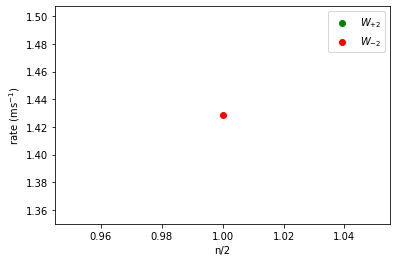

In [23]:
plotting=True
if plotting:
    x_values = df.query('dn==2').n/2
    y_values = df.query('dn==2').rates
    plt.scatter(x=x_values,y=y_values, c='g', label='$W_{+2}$')
    x_values = df.query('dn==-2').n/2
    y_values = df.query('dn==-2').rates
    plt.scatter(x=x_values,y=y_values, c='r', label='$W_{-2}$')

    plt.legend()
    plt.xlabel('n/2')
    plt.ylabel('rate (ms$^{-1}$)')